# Contenuti
- [Scikit-learn](#Scikit-learn)
- [Import delle librerie](#Import-delle-librerie)
- [Dataset](#Dataset)
- [Classificazione](#Classificazione)
    - [k-NN e SVM](#k-NN-e-SVM)
- [Cross-Validation](#Cross-Validation)
- [Grid Search e Cross-Validation](#Grid-Search-e-Cross-Validation)
- [Ottimizzazione iperparametri](#Ottimizzazione-iperparametri)
- [Test](#Test)

# Esercitazione 3
Nell'esercitazione odierna si vedrà come applicare gli algoritmi *k-NN* e *SVM* a un problema di classificazione multiclasse. A tal fine verrà utilizzata la libreria **Scikit-learn**, di cui sarà descritta l'API per l'addestramento e uso di classificatori. Nel corso dell'esercitazione si dovranno individuare le combinazioni di iperparametri che permettono di massimizzare l’accuratezza dei due classificatori sui dataset forniti tramite *Cross-Validation* e *Grid Search*.

Infine si dovrà verificare l'accuratezza della soluzione trovata sul dataset di test per provarne l’effettiva capacità di generalizzazione.

# Scikit-learn
Scikit-learn è una libreria open source per Python che mette a disposizione numerose classi e funzionalità specifiche per il Machine Learning. Oltre a rendere disponibili i più comuni algoritmi per la classificazione, regressione e clustering, sono presenti anche diverse funzionalità per la manipolazione dei dati.

La popolarità di Scikit-learn è dovuta principalmente alla sua facilità d'uso, all'integrazione con la libreria Numpy e alla possibilità di parametrizzare le operazioni messe a disposizione, pur mantenendo una API semplice.

Per una lista completa delle funzionalità si rimanda alla [documentazione ufficiale](http://scikit-learn.org/stable/documentation.html).

# Import delle librerie
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione. Il package della libreria Scikit-learn è denominato **sklearn**. Dal package è possibile caricare solamente i moduli necessari.

In [19]:
import pandas as pd
import os
import numpy as np
# Moduli di scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split, StratifiedShuffleSplit, StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix

import ml_utilities
import ml_visualization

In [2]:
TESTS_PATH = "./tests/"
INFO_PATH = "./tests/experiments_info"

# Dataset
Il dataset messo a disposizione consiste in un insieme di cifre (0-9) scritte a mano.
<img src="dataset_resample.png" alt="Processing training set" style="width: 600px;"/>

I dataset di training "pendigits_tr.txt" e "pendigits_tr_Pca_K2.txt" contengono entrambi 442 pattern etichettati (cifre da 0 a 9). Il primo contiene pattern 16-dimensionali (le coordinate x,y di otto punti equispaziati dopo normalizzazione e *resampling*) mentre il secondo consiste in una versione bidimensionale ottenuta tramite riduzione della dimensionalità (mediante l'algoritmo *Principal Component Analysis*), utile per eseguire test iniziali visualizzando pattern e risultati.

Di seguito è fornita la procedura per il caricamento del dataset. È necessario assegnare alla variabile *dataset_path* il percorso dove sono memorizzati i due file. Tramite la variabile *feature_count* è possibile dichiarare quale delle due versioni del dataset si intende utilizzare.

In [3]:
# Scelta del dataset da utilizzare (16 o 2 features)
feature_count = 2
dataset_path = 'DBs/PenDigits/pendigits_tr_Pca_K2.txt'  # Impostare il percorso corretto

# Caricamento del dataset
dataset_patterns, dataset_labels = ml_utilities.load_labeled_dataset_from_txt(dataset_path, feature_count)
print('Shape dataset:', dataset_patterns.shape)
print('Shape labels:', dataset_labels.shape)

Shape dataset: (442, 2)
Shape labels: (442,)


Il dataset caricato può essere suddiviso in due parti: training e validation set. Attraverso il validation set sarà possibile valutare i risultati del classificatore addestrato sul training set al fine di individuare il valore ottimale per gli iperparametri.

Visto che in Machine Learning è comune eseguire tale operazione, la libreria Scikit-learn mette a disposizione una apposita funzione, [**train_test_split(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), che permette di separare un dataset in due parti. 

Il parametro *test_size* descrive la percentuale di pattern che dovrà essere contenuta nella seconda parte. Come configurazione predefinita **train_test_split(...)** mescola i pattern al fine di evitare che i dataset restituiti contengano pattern appartenenti solamente a un sottoinsieme delle classi.

In [4]:
#add shuffle for more randomness
train_x, validation_x, train_y, validation_y = train_test_split(dataset_patterns, dataset_labels, test_size=0.25,shuffle=True)

print('Shape training set:', train_x.shape)
print('Shape validation set:', validation_x.shape)


Shape training set: (331, 2)
Shape validation set: (111, 2)


# Classificazione
Di seguito vengono descritte le operazioni necessarie per creare e addestrare un classificatore. Uno dei punti di forza della libreria Scikit-learn è la sua facilità d'uso e l'uniformità delle chiamate alla libreria: si noti come queste operazioni necessitino solamente di due linee di codice.

In [5]:
# Creazione di un classificatore
dummy_clf = DummyClassifier(strategy='most_frequent')

Nell'esempio, il classificatore creato è un **DummyClassifier** la cui strategia è quella di assegnare ad ogni pattern la classe più numerosa nel training set.

Il classificatore (*estimator* nel lessico di Scikit-learn) può essere addestrato tramite il metodo **.fit(...)** che prende in input un insieme di pattern etichettati X,y. I pattern (X) sono memorizzati per righe in un Numpy array bidimensionale mentre le etichette (y) in un Numpy array monodimensionale.

N.B.: la notazione X (maiuscolo) e y (minuscolo) è normalmente utilizzata in Scikit-learn per indicare un set di pattern (X) e le rispettive etichette (y).

In [6]:
# Addestramento
dummy_clf.fit(train_x, train_y)

DummyClassifier(strategy='most_frequent')

Una volta addestrato, un classificatore può essere utilizzato per riconoscere la classe di uno o più pattern. Per fare ciò, si può utilizzare il metodo **.predict(...)** passando come parametro una lista di pattern. Il risultato che si ottiene è una lista delle label predette dal classificatore.

In [7]:
# Uso della funzione .predict(...)
print('Classi predette:', dummy_clf.predict(validation_x[0:10]))
print('Classi reali:', validation_y[0:10])

Classi predette: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
Classi reali: [8. 7. 1. 0. 5. 1. 3. 1. 7. 3.]


In Scikit-learn è possibile misurare l'accuratezza di un classificatore su un determinato dataset richiamando il metodo **.score(...)** che prende in input un insieme di pattern etichettati X,y. Internamente il metodo classifica ogni singolo pattern di X e verifica se l'etichetta assegnata corrisponde alla corrispondente *entry* in y.

In [8]:
# Uso della funzione .score(...)
print('Accuratezza sul training set: %.3f' % dummy_clf.score(train_x, train_y))
print('Accuratezza sul validation set: %.3f' % dummy_clf.score(validation_x, validation_y))

Accuratezza sul training set: 0.139
Accuratezza sul validation set: 0.108


Si implementi la funzione **compute_accuracy(...)** in grado di calcolare l'accuratezza di un classificatore su un insieme di pattern etichettati X,y.

In [9]:
# Esercizio di approfondimento: stima dell'accuratezza
def compute_accuracy(classifier, X, y):
    return  classifier.score(X,y)

print('Accuratezza sul training set: %.3f' % compute_accuracy(dummy_clf, train_x, train_y))
print('Accuratezza sul validation set: %.3f' % compute_accuracy(dummy_clf, validation_x, validation_y))

Accuratezza sul training set: 0.139
Accuratezza sul validation set: 0.108


Per dati bidimensionali può essere utile visualizzare graficamente i pattern e la superfice decisionale del classificatore. Per fare ciò si può utilizzare la funzione **show_2D_results(...)** presente nel modulo ml_visualization.

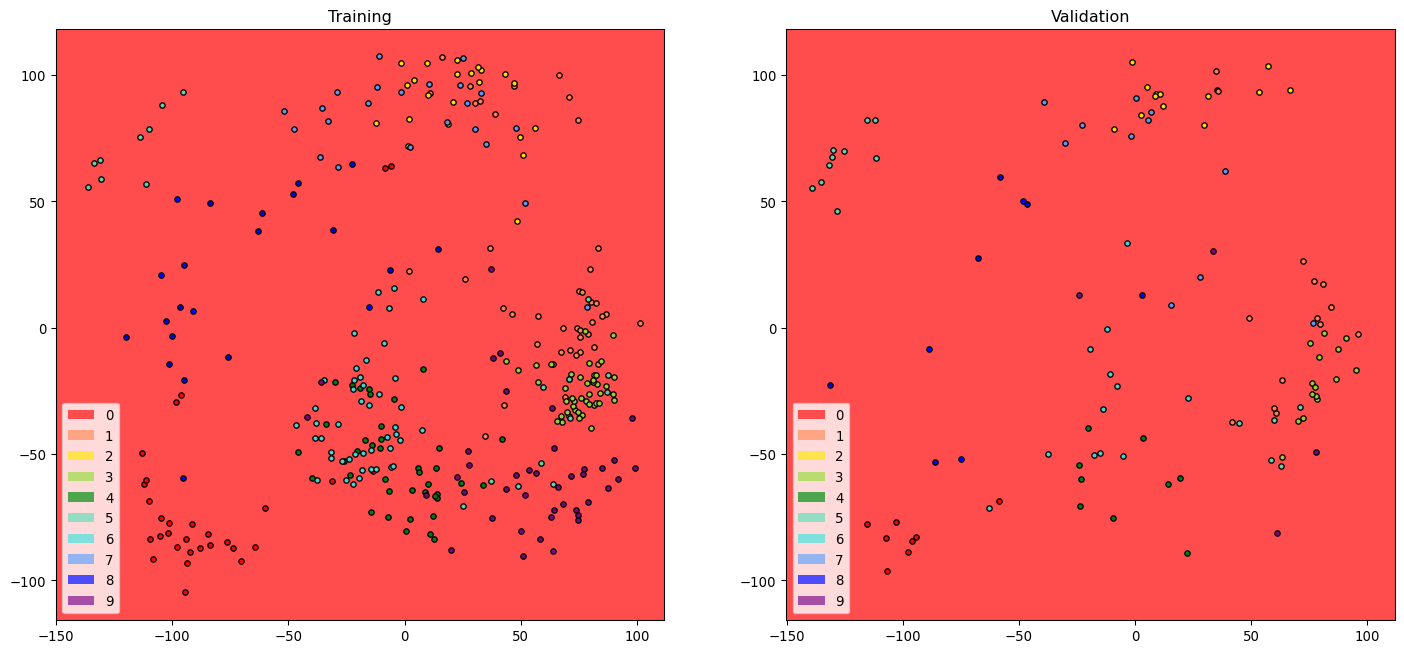

In [10]:
# Uso di show_results
ml_visualization.show_2D_results(dummy_clf, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'))

## k-NN e SVM
Abbiamo visto come, con Scikit-learn, sia possibile creare, addestrare e utilizzare un generico classificatore. Scikit-learn mette a disposizione una serie di classificatori tra cui [k-NN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) e [SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) che utilizzeremo per riconoscere i pattern caricati in precedenza.

Accuratezza KNN
Sul training set: 1.000
Sul validation set: 0.649



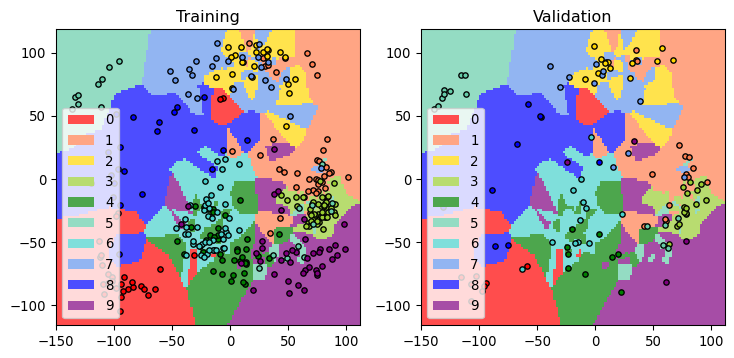

Accuratezza SVC con kernel = linear
Sul training set: 0.668
Sul validation set: 0.568



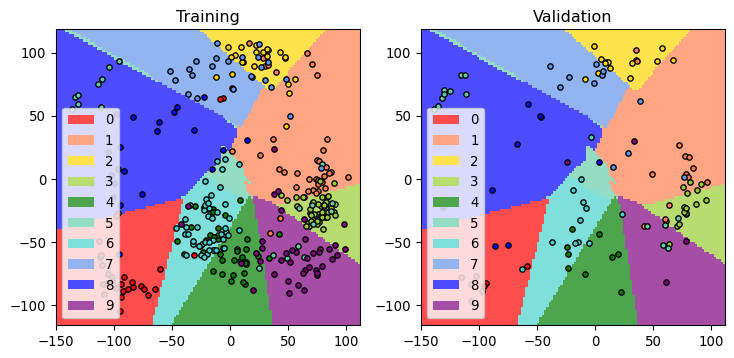

Accuratezza SVC con kernel = rbf
Sul training set: 0.888
Sul validation set: 0.550



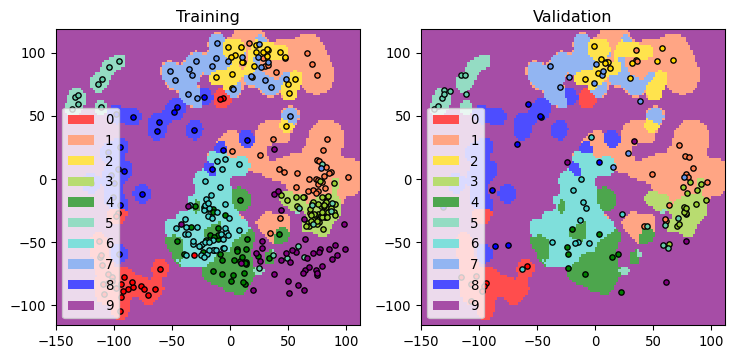

In [11]:
# Esercizio 1: creare ed addestrare un classificatore

clfKNN = KNeighborsClassifier(n_neighbors=1, weights= 'uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                           metric_params=None, n_jobs=None)
clfKNN.fit(train_x,train_y)
# Calcolo accuratezza KNN
print(f"Accuratezza KNN")
print('Sul training set: %.3f' % clfKNN.score(train_x, train_y))
print('Sul validation set: %.3f\n' % clfKNN.score(validation_x, validation_y))
ml_visualization.show_2D_results(clfKNN, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'), figsize=(9, 4))
kernel = ['linear','rbf']
for k in kernel:
    clfSVC = SVC(C=1.0, kernel=k,degree=3,gamma=0.025, coef0=0.0, shrinking=True, probability=False, tol=1e-3, cache_size=200,
             class_weight=None,verbose=False,max_iter=-1,decision_function_shape="ovr",break_ties=False, random_state=None)
    clfSVC.fit(train_x,train_y,sample_weight=None)
    # Calcolo accuratezza SVC
    print(f"Accuratezza SVC con kernel = {k}")
    print('Sul training set: %.3f' % clfSVC.score(train_x, train_y))
    print('Sul validation set: %.3f\n' % clfSVC.score(validation_x, validation_y))
    ml_visualization.show_2D_results(clfSVC, (train_x, train_y, 'Training'), (validation_x, validation_y, 'Validation'), figsize=(9, 4))


# Cross-Validation
Se non si vuole riservare un sottoinsieme disgiunto per il validation set e sfruttare tutti i dati disponibili per training e validazione, si può utilizzare la tecnica *Cross-Validation* vista a lezione.  

Si completi il codice nella cella seguente richiamando la funzione [**cross_val_score(...)**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) di Scikit-learn che stima l'accuratezza di un classificatore (*estimator*) tramite *Cross-Validation* (con un numero di *fold* pari a *cv*).

In [12]:
# Esercizio 2: eseguire la Cross Validation utilizzando la funzione cross_val_score
# Reminder: la variabile dataset_patterns include già training e validation set

# Hyperparameter to test = cv..
cv_score = cross_val_score(clfKNN,dataset_patterns,dataset_labels,cv=4)
print('Risultati CrossValidation:\n', cv_score)

Risultati CrossValidation:
 [0.65765766 0.56756757 0.65454545 0.61818182]


# Grid Search e Cross-Validation
Dato un algoritmo, la ricerca degli iperparametri ottimi può essere automatizzata utilizzando, come visto a lezione, la classe [**GridSearchCV**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) messa a disposizione da Scikit-learn.

Questo metodo è particolarmente indicato nei casi in cui l'addestramento di un classificatore non richieda un tempo particolarmente lungo. Si consideri infatti che vengono creati e addestrati $(\textit{# combinazioni degli iperparametri} \times \textit{# fold}) + 1$ classificatori.

Combinazioni di parametri:
 [{'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.025, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.025, 'kernel': 'rbf'}]
Accuratezza media per combinazione:
 [0.45935026 0.56797707 0.42615343 0.53166803]
Combinazione migliore:
 {'C': 1, 'gamma': 0.025, 'kernel': 'rbf'}
Accuratezza media della combinazione migliore: 0.568


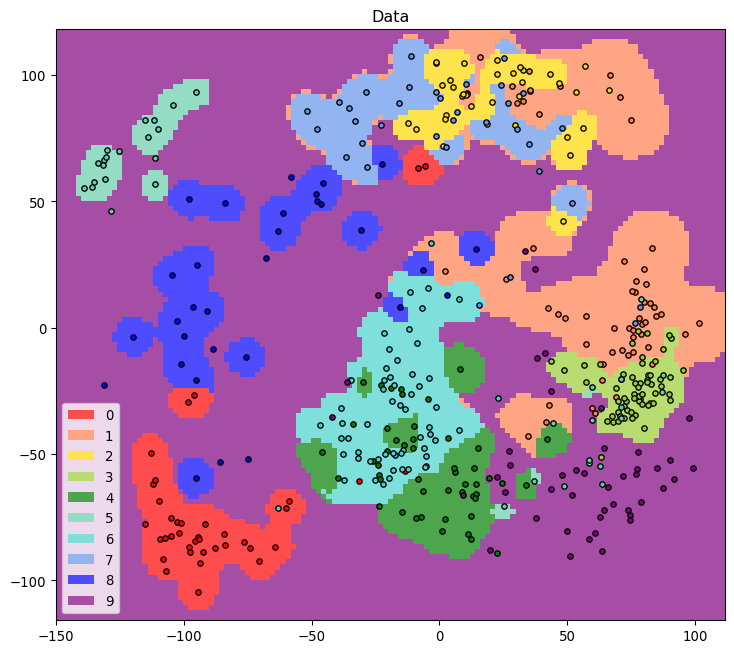

In [13]:
# Creazione di un classificatore di tipo SVM
clf = SVC()

# Creazione della griglia di iperparametri
param_grid = [{'kernel': ['rbf'], 'C': [1,10], 'gamma': [0.05,0.025]}]

# Numero di fold per la Cross-validation
n_folds = 3

# Creazione di un oggetto (modello) di tipo GridSearchCV
grid_search_cv = GridSearchCV(clf, param_grid, cv=n_folds)

# Esecuzione della ricerca degli iperparametri
grid_search_cv.fit(train_x, train_y)

# Stampa risultati
print('Combinazioni di parametri:\n', grid_search_cv.cv_results_['params'])
print('Accuratezza media per combinazione:\n', grid_search_cv.cv_results_['mean_test_score'])
print('Combinazione migliore:\n', grid_search_cv.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)

# Visualizzazione 2D
ml_visualization.show_2D_results(grid_search_cv.best_estimator_,
                                 (dataset_patterns, dataset_labels, 'Data'),
                                 figsize=(9, 8))

Se si vuole testare esternamente al **GridSearchCV(...)** i migliori iperparametri precedentemente individuati (*best_params_*), si consiglia di verificarne la bontà utilizzando la funzione **cross_val_score(...)** che restituisce l'accuratezza per le singole _fold_. Viceversa, utilizzando l'intero training set sia per l'addestramento che per la valutazione si rischia di ottenere un valore di accuratezza non realistico. 

In [14]:
# Costruisce un classificatore con i parametri trovati
clf = SVC(**grid_search_cv.best_params_)
print('Classificatore con parametri ottimali:\n', clf, '\n')

# Cross validation
cv_score = cross_val_score(clf, train_x, train_y, cv=n_folds)
print('Accuracy di cross validation: ', cv_score)
print('Accuracy media di cross validation: ', cv_score.mean())

# Addestramento su tutto il dataset
clf = SVC(**grid_search_cv.best_params_)
clf.fit(train_x, train_y)
print('Accuracy classificatore addestrato su tutto il training set:', clf.score(train_x, train_y))

Classificatore con parametri ottimali:
 SVC(C=1, gamma=0.025) 

Accuracy di cross validation:  [0.56756757 0.53636364 0.6       ]
Accuracy media di cross validation:  0.5679770679770679
Accuracy classificatore addestrato su tutto il training set: 0.8882175226586103


# Ottimizzazione iperparametri
Si individui il classificatore (*k-NN* o *SVM*) e la rispettiva combinazione di iperparametri che permettono di massimizzare l'accuratezza sul dataset fornito (16-dimensionale).

Si consiglia di procedere eseguendo **GridSearchCV** su un insieme limitato di combinazioni raffinando la ricerca degli iperparametri in iterazioni successive. In questa maniera sarà possibile ridurre i tempi di attesa.

Nella cella seguente è riportata la procedura per il caricamento del dataset:

In [15]:
# Caricamento del dataset
feature_count = 16
dataset_path = 'DBs/PenDigits/pendigits_tr.txt'  # Impostare il percorso corretto

dataset_patterns, dataset_labels = ml_utilities.load_labeled_dataset_from_txt(dataset_path, feature_count)

Utilizzando il dataset appena caricato si identifichi una combinazione di iperparametri ottimi. A tal fine nella cella seguente è possibile sperimentare le tecniche viste in questa esercitazione.

In [35]:
# Stampa risultati
def print_result(grid_search_cv):
    print('Accuratezza media per combinazione:\n', grid_search_cv.cv_results_['mean_test_score'])
    print('Combinazione migliore:\n', grid_search_cv.best_params_)
    print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)
                # Stampa risultati


In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split, StratifiedShuffleSplit
import ml_utilities
import ml_visualization

def normalizeData(dataset_patterns, test_x):

    scaler = MinMaxScaler()
    # alldata = np.concatenate((dataset_patterns, test_x))
    # transformed_data = scaler.fit_transform(alldata)

    transformed_data_train = scaler.fit_transform(dataset_patterns)
    transformed_data_test = scaler.fit_transform(test_x)


    # dataset_patterns = transformed_data[:442]
    # test_x = transformed_data[442:]
    return transformed_data_train, transformed_data_test

def readData():
    feature_count = 16
    dataset_path = 'DBs/PenDigits/pendigits_tr.txt'  # Impostare il percorso corretto

    dataset_patterns, dataset_labels = ml_utilities.load_labeled_dataset_from_txt(dataset_path, feature_count)
    test_path = 'DBs/PenDigits/pendigits_te.txt'
    test_x = ml_utilities.load_unlabeled_dataset_from_txt(test_path, feature_count)
    return dataset_patterns, dataset_labels, test_x

class BestParams:
    _bestparams = None
    _t_size = 0
    _split = 0

    def update(self, bestparams, t_size, split):
        self._bestparams = bestparams
        self._t_size = t_size
        self._split = split

    def isbetter(self, score):
        if self._bestparams is None: return True
        # print(score.cv_results_['mean_test_score'], self._bestparams['cv_results_'])
        return score.cv_results_['mean_test_score'] > self._bestparams.cv_results_['mean_test_score']

    def printVals(self):
        print("_bestparams: ", self._bestparams.best_params_)
        print("_t_size: ", self._t_size)
        print("_split: ", self._split)
bestparams = BestParams()

def getOttimalClassifier():
    data = {
        't_size',
        'split',
        'grid_search_cv'
        'algorithm',
        'metric',
        'n_neighbors',
        'weights'
    }
    dataframe = pd.DataFrame(data)
    for t_size in [0.25]:
        dataframe['test_size'] = t_size
        for split in [5]:
            print(f"TEST = {t_size}%, SPLIT = {split}")
            gamma = [2**i for i in range(-15,4)]
            gamma = np.append(gamma, 0.00009111627561154887)

            C = [2**i for i in range(-5,16)]
            C = np.append(C, 1)


            # degree = [i for i in range(1,30)]
            param_grid = [{'kernel': ['rbf'], 'C': C, 'gamma': gamma}]
            # param_grid = [{'kernel': ['poly'], 'C': C, 'gamma': gamma, 'degree': [5,6,7,8,9,10]}]

            cross_val = StratifiedShuffleSplit(n_splits=split, test_size=t_size, random_state=42)
            grid_search_cv = GridSearchCV(SVC(), param_grid, cv=cross_val, verbose=2)
            grid_search_cv.fit(dataset_patterns, dataset_labels)

            if bestparams.isbetter(grid_search_cv):
                bestparams.update(grid_search_cv,t_size,split)


    return grid_search_cv


data_patterns, data_labels, test_x = readData()
dataset_patterns, test_x = normalizeData(dataset_patterns, test_x)
print()

grid_search_cv = getOttimalClassifier()
print(grid_search_cv.cv_results_['mean_test_score'])
bestparams.printVals()


clf = SVC(**grid_search_cv.best_params_, random_state=42)
# Addestramento del classificatore
clf.fit(data_patterns, data_labels)
# Calcolo delle prediction
predictions = clf.predict(test_x)
print(clf.score(data_patterns, data_labels))
# inizializzazione SVC con opportuni parametri
# creazione param_grid per SVC

# selezionare numero di fold

# creazione GridSearch per KNN e SV
# esecuzione del fitting per tuStti e due
# stampare risultati (combinazione migliore + accuratezza, accuratezza media)



TEST = 0.25%, SPLIT = 5
Fitting 5 folds for each of 440 candidates, totalling 2200 fits
[CV] END ......C=0.03125, gamma=3.0517578125e-05, kernel=rbf; total time=   0.0s
[CV] END ......C=0.03125, gamma=3.0517578125e-05, kernel=rbf; total time=   0.0s
[CV] END ......C=0.03125, gamma=3.0517578125e-05, kernel=rbf; total time=   0.0s
[CV] END ......C=0.03125, gamma=3.0517578125e-05, kernel=rbf; total time=   0.0s
[CV] END ......C=0.03125, gamma=3.0517578125e-05, kernel=rbf; total time=   0.0s
[CV] END .......C=0.03125, gamma=6.103515625e-05, kernel=rbf; total time=   0.0s
[CV] END .......C=0.03125, gamma=6.103515625e-05, kernel=rbf; total time=   0.0s
[CV] END .......C=0.03125, gamma=6.103515625e-05, kernel=rbf; total time=   0.0s
[CV] END .......C=0.03125, gamma=6.103515625e-05, kernel=rbf; total time=   0.0s
[CV] END .......C=0.03125, gamma=6.103515625e-05, kernel=rbf; total time=   0.0s
[CV] END .......C=0.03125, gamma=0.0001220703125, kernel=rbf; total time=   0.0s
[CV] END .......C=0.0

In [67]:
print(data_patterns)

[[ 54.53202  93.20363  93.14803 ...  19.58096   8.5355  -16.56865]
 [ 23.81184  74.58217  47.32371 ...   6.42339 128.62086  41.99632]
 [ 19.93094  38.03077  80.22549 ...  25.22798  43.74117  19.54822]
 ...
 [ 48.94473 112.48547  97.87831 ...   8.76816  -4.71426  19.69023]
 [ 11.48606  73.8479   10.88518 ...  71.13745  66.25253 -30.4388 ]
 [-17.90296  98.55107  17.04255 ...   3.92084 -15.52233 -19.16435]]


In [42]:
type(grid_search_cv.best_params_)

dict

In [27]:
print_result(grid_search_cv)

Accuratezza media per combinazione:
 [0.66975309 0.66975309 0.63007055 0.67460317 0.62037037 0.65873016
 0.58906526 0.63227513 0.56216931 0.61243386 0.53439153 0.59259259
 0.50749559 0.57804233 0.47310406 0.55952381 0.43342152 0.54056437
 0.39197531 0.5207231  0.36155203 0.50881834 0.32848325 0.49514991
 0.28571429 0.48677249 0.2372134  0.47839506 0.66975309 0.66975309
 0.63007055 0.67460317 0.62037037 0.65873016 0.58906526 0.63227513
 0.56216931 0.61243386 0.53439153 0.59259259 0.50749559 0.57804233
 0.47310406 0.55952381 0.43342152 0.54056437 0.39197531 0.5207231
 0.36155203 0.50881834 0.32848325 0.49514991 0.28571429 0.48677249
 0.2372134  0.47839506 0.65123457 0.65123457 0.62169312 0.66358025
 0.61552028 0.64550265 0.585097   0.62742504 0.56834215 0.60493827
 0.54100529 0.58950617 0.49779541 0.57627866 0.45414462 0.5489418
 0.42857143 0.5361552  0.39594356 0.51455026 0.36287478 0.50044092
 0.32936508 0.48148148 0.28835979 0.47310406 0.24691358 0.46252205
 0.66975309 0.66975309 0.63

In [32]:
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
clfKNN = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski', algorithm='ball_tree')
grid_search_cv = GridSearchCV(clfKNN, param_grid, cv=cv)
# Esecuzione della ricerca degli iperparametri
grid_search_cv.fit(train_x, train_y)
print('Combinazione migliore:\n', grid_search_cv.best_params_)
print('Accuratezza media della combinazione migliore: %.3f' % grid_search_cv.best_score_)

Combinazione migliore:
 {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
Accuratezza media della combinazione migliore: 0.905


In [36]:
print_result(grid_search_cv)

Accuratezza media per combinazione:
 [0.73809524 0.73809524 0.78571429 0.78571429 0.9047619  0.88095238
 0.88095238 0.88095238 0.88095238 0.88095238 0.85714286 0.85714286
 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
 0.80952381 0.83333333 0.80952381 0.83333333 0.80952381 0.80952381
 0.78571429 0.78571429 0.80952381 0.80952381 0.73809524 0.73809524
 0.78571429 0.78571429 0.9047619  0.88095238 0.88095238 0.88095238
 0.88095238 0.88095238 0.85714286 0.85714286 0.83333333 0.83333333
 0.83333333 0.83333333 0.83333333 0.83333333 0.80952381 0.83333333
 0.80952381 0.83333333 0.80952381 0.80952381 0.78571429 0.78571429
 0.80952381 0.80952381 0.76190476 0.76190476 0.80952381 0.85714286
 0.85714286 0.9047619  0.88095238 0.9047619  0.83333333 0.83333333
 0.83333333 0.83333333 0.80952381 0.83333333 0.78571429 0.83333333
 0.76190476 0.78571429 0.76190476 0.78571429 0.78571429 0.78571429
 0.78571429 0.78571429 0.78571429 0.78571429 0.78571429 0.78571429
 0.73809524 0.73809524 0.

In [ ]:
print('Classi predette:', grid_search_cv.predict(validation_x[0:10]))
print('Classi reali:', validation_y[0:10])

## Salvataggio GridSearch
Salvataggio del GridSearchCV in un dataframe e storing in un file

In [25]:
dataframe = pd.concat([pd.DataFrame(grid_search_cv.cv_results_["params"]),pd.DataFrame(grid_search_cv.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1).sort_values(by='Accuracy', ascending=False)
dataframe

,algorithm,metric,n_neighbors,weights,Accuracy
171,kd_tree,euclidean,3,distance,0.674603
283,brute,minkowski,3,distance,0.674603
3,ball_tree,minkowski,3,distance,0.674603
87,ball_tree,l2,3,distance,0.674603
367,brute,l2,3,distance,0.674603
...,...,...,...,...,...
390,brute,l2,27,uniform,0.237213
250,kd_tree,l2,27,uniform,0.237213
110,ball_tree,l2,27,uniform,0.237213
166,kd_tree,minkowski,27,uniform,0.237213


In [17]:
n_test = 2
if not os.path.exists(TESTS_PATH):
    os.makedirs(TESTS_PATH)

# Attenzione a non sovrascrivere i precedenti (cambiare n_test)
dataframe.to_pickle(TESTS_PATH+"/GridSearchCV_"+ str(n_test))

NameError: name 'dataframe' is not defined

In [22]:
dataframe = pd.read_pickle(TESTS_PATH+"/GridSearchCV_2")
dataframe

,algorithm,metric,n_neighbors,weights,Accuracy
31,ball_tree,euclidean,3,distance,0.82346
87,ball_tree,l2,3,distance,0.82346
367,brute,l2,3,distance,0.82346
143,kd_tree,minkowski,3,distance,0.82346
283,brute,minkowski,3,distance,0.82346
...,...,...,...,...,...
250,kd_tree,l2,27,uniform,0.71492
334,brute,euclidean,27,uniform,0.71492
26,ball_tree,minkowski,27,uniform,0.71492
54,ball_tree,euclidean,27,uniform,0.71492


# Test
Si addestri il classificatore desiderato utilizzando gli iperparametri trovati nell'esercizio precedente. Il codice contenuto nella cella seguente userà tale classificatore per predire la classe dei pattern del dataset di test. Le classi predette verranno salvate su un file di testo che dovrà essere caricato sul sito della competizione per misurarne l'accuratezza.

Il file "pendigits_te.txt" contiene 5000 pattern 16-dimensionali non etichettati.

Sul sito della competizione dovrà essere caricato uno zip contenente sia il file di testo "Es3Predictions.txt" che una cartella "Codice" contenente il codice (notebook e script) da utilizzare per replicare il risultato.

Nota: all'interno dello zip il file "Es3Predictions.txt" non deve essere contenuto in una cartella.

In [ ]:
# Esercizio 4: valutazione su test set

result_path = 'Es3Predictions.txt'

# Caricamento del dataset
feature_count = 16
test_path = 'DBs/PenDigits/pendigits_te.txt'

test_x = ml_utilities.load_unlabeled_dataset_from_txt(test_path, feature_count)

# Creazione del classificatore
### inserimento del miglior classificatore trovato ###
clf = ...

# Addestramento del classificatore
clf.fit(dataset_patterns, dataset_labels)

# Calcolo delle prediction
predictions = clf.predict(test_x)

# Salvataggio delle prediction
with open(result_path, "w") as f:
    for prediction in predictions:
        f.write(str(int(prediction)) + '\n')
print('Salvataggio delle prediction riuscito')